# TrendCart
## Integrating Viral Food Trend Predictions into Grocery Stores Demand Forecasting

This is the combined notebook based on the research done in the `data_exploration` folder.

In [1]:
%pip install pandas numpy matplotlib pytrends spoonacular brave-search scikit-learn xgboost tensorflow sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from spoonacular import API
import json
import time
import os
from brave import Brave
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/opt/homebrew/Caskroom/miniconda/base/envs/cs4365/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Training
To create a forecasting pipeline, we need to create a base model. We do this by training several ML models and seeing which is most successful.

Given the previous research done, we start with the numpy sales array dataset created.

In [3]:
sales_array = np.load('./data/sales_array.npy')
sales_array

array([[[ 7., 18.,  4., ...,  0.,  0.,  0.],
        [ 8., 23.,  5., ...,  0.,  0.,  0.],
        [ 8., 17.,  5., ...,  1.,  0.,  0.],
        ...,
        [10., 13.,  3., ...,  0.,  1.,  0.],
        [ 2., 19.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 8., 16.,  5., ...,  0.,  0.,  0.],
        [17., 26.,  9., ...,  0.,  0.,  0.],
        [11., 28.,  9., ...,  0.,  0.,  0.],
        ...,
        [13., 23.,  9., ...,  0.,  0.,  0.],
        [10., 15., 12., ...,  0.,  0.,  0.],
        [ 5., 13.,  6., ...,  0.,  0.,  0.]]])

We then remove the first and last weeks as they are outliers and reshape the dataset into an array of weeks.

In [4]:
# Remove outlier weeks
trimmed_data = sales_array[:, 1:-1, :]

# Reshape the array to a 2D format
num_samples = sales_array.shape[0] * sales_array.shape[1]
num_features = sales_array.shape[2]
reshaped_data = sales_array.reshape((num_samples, num_features))

reshaped_data

array([[ 7., 18.,  4., ...,  0.,  0.,  0.],
       [ 8., 23.,  5., ...,  0.,  0.,  0.],
       [ 8., 17.,  5., ...,  1.,  0.,  0.],
       ...,
       [13., 23.,  9., ...,  0.,  0.,  0.],
       [10., 15., 12., ...,  0.,  0.,  0.],
       [ 5., 13.,  6., ...,  0.,  0.,  0.]])

We then normalize the data and create a dataframe. 

In [6]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(reshaped_data)

# Create a DataFrame from the scaled data
data = pd.DataFrame(scaled_data)

data

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.291667,0.400000,0.285714,0.483871,0.481481,1.00,0.285714,0.454545,0.1875,0.090909,...,0.75,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.333333,0.511111,0.357143,0.419355,0.740741,0.50,0.238095,0.454545,0.1250,0.090909,...,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.377778,0.357143,0.548387,0.888889,0.50,0.190476,0.000000,0.1250,0.181818,...,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.291667,0.266667,0.428571,0.419355,0.703704,0.00,0.285714,0.363636,0.0000,0.181818,...,0.50,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.208333,0.422222,0.428571,0.483871,0.629630,0.00,0.238095,0.363636,0.1250,0.181818,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.500000,0.733333,0.642857,0.741935,0.703704,0.25,0.285714,0.363636,0.7500,1.000000,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
102,0.375000,0.644444,0.785714,0.483871,0.481481,0.25,0.238095,0.272727,0.6875,0.545455,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.541667,0.511111,0.642857,0.709677,0.555556,0.50,0.238095,0.545455,0.7500,0.636364,...,0.50,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.416667,0.333333,0.857143,0.677419,0.296296,0.50,0.476190,0.272727,0.5000,0.636364,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We then split the data into train, validation, and test. We create this by shifting the dataset so each week's features have a target of next week's features.

In [7]:
# Assuming the data is sorted chronologically
train_size = int(len(data) * 0.8)

# Split the data into train and test sets
train_data = data[:train_size]
test_data = data[train_size:]

# Split the train data into train and validation sets
train_size = int(len(train_data) * 0.8)
val_data = train_data[train_size:]
train_data = train_data[:train_size]

# Separate features and target variable for each set
X_train = train_data.to_numpy()
y_train = pd.concat([train_data.iloc[1:], train_data.iloc[:1]]).reset_index(drop=True).to_numpy()
X_val = val_data.to_numpy()
y_val = pd.concat([val_data.iloc[1:], val_data.iloc[:1]]).reset_index(drop=True).to_numpy()
X_test = test_data.to_numpy()
y_test = pd.concat([test_data.iloc[1:], test_data.iloc[:1]]).reset_index(drop=True).to_numpy()

We then train several models.

We choose classical ML models that are used for forecasting such as linear regression, random forest, and XGBoost.

Since we expect the data may contain nonlinear patterns, we also choose timeseries-based deeper models such as RNN and LSTM.

In [35]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print("Linear Regression R^2 Score:", lr_score)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_score = rf_model.score(X_test, y_test)
print("Random Forest R^2 Score:", rf_score)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_score = xgb_model.score(X_test, y_test)
print("XGBoost R^2 Score:", xgb_score)

# RNN
rnn_model = Sequential()
rnn_model.add(SimpleRNN(256, activation='relu', input_shape=(1, X_train.shape[1])))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dense(sales_array.shape[-1]))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_rnn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
rnn_model.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val), epochs=50, batch_size=32)
rnn_score = rnn_model.evaluate(X_test_rnn, y_test)
print("RNN Mean Squared Error:", rnn_score)

# LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(sales_array.shape[-1]))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=50, batch_size=32)
lstm_score = lstm_model.evaluate(X_test_reshaped, y_test)
print("LSTM Mean Squared Error:", lstm_score)

Linear Regression R^2 Score: -0.9981017506615912
Random Forest R^2 Score: -0.15533955861504445
XGBoost R^2 Score: -0.6429575482844548
Epoch 1/50


/opt/homebrew/Caskroom/miniconda/base/envs/cs4365/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1403 - val_loss: 0.1156
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1088 - val_loss: 0.0999
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0932 - val_loss: 0.0888
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0813 - val_loss: 0.0796
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0721 - val_loss: 0.0725
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0646 - val_loss: 0.0678
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0594 - val_loss: 0.0656
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0561 - val_loss: 0.0653
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0541 - val_loss: 0.0657
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0529 - val_loss: 0.0655
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0519 - val_loss: 0.0651
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0509 - val_loss: 0.0644
Epoch 13/50
3/3 ━━━━━

We find negative $R^2$ values for all classical ML models meaning that not only do they not capture the patterns, but they perform worse than a normal distribution. This means we must turn to our deeper models. The models perform well, so we will explore them further.

We find that our models perform well, but only use the previous weeks data. In a real world sense, we want to use multiple weeks data to see if we can get more accurate predictions.

We choose three weeks.

In [36]:
# LSTM with past 3 time steps
timesteps = 3

# Prepare the input data for LSTM
def create_dataset(X, y, timesteps):
    X_data, y_data = [], []
    for i in range(len(X) - timesteps):
        X_data.append(X[i:(i + timesteps), :])
        y_data.append(y[i + timesteps])
    return np.array(X_data), np.array(y_data)

X_train_step, y_train_step = create_dataset(X_train, y_train, timesteps)
X_val_step, y_val_step = create_dataset(X_val, y_val, timesteps)
X_test_step, y_test_step = create_dataset(X_test, y_test, timesteps)


print(X_train_step.shape)
lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='relu', input_shape=(timesteps, X_train.shape[1])))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(sales_array.shape[-1]))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


lstm_model.fit(X_train_step, y_train_step, validation_data=(X_val_step, y_val_step), epochs=50, batch_size=32)
lstm_score = lstm_model.evaluate(X_test_step, y_test_step)
print("LSTM Mean Squared Error:", lstm_score)

rnn_model = Sequential()
rnn_model.add(SimpleRNN(256, activation='relu', input_shape=(timesteps, X_train.shape[1])))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dense(sales_array.shape[-1]))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.fit(X_train_step, y_train_step, validation_data=(X_val_step, y_val_step), epochs=50, batch_size=32)
rnn_score = rnn_model.evaluate(X_test_step, y_test_step)
print("RNN Mean Squared Error:", rnn_score)

(64, 3, 167)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.1303 - val_loss: 0.1214
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1171 - val_loss: 0.1097
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1069 - val_loss: 0.0982
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0954 - val_loss: 0.0876
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0839 - val_loss: 0.0785
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0764 - val_loss: 0.0719
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0691 - val_loss: 0.0667
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0630 - val_loss: 0.0635
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0599 - val_loss: 0.0614
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0566 - val_loss: 0.0599
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0548 - val_loss: 0.0597
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0547 - val_

These models perform much better. We see that the RNN and LSTM both perform with similar MSE scores. However, we are only predicting using three timesteps of data. RNN is better suited for smaller timesteps, while LSTM is better for capturing long-term trends. Our data in both training and at the inference step will be shorter term, so we go with RNN.

We then save this model.

In [44]:
rnn_model.save('./data/rnn_model.keras')

In order to be able to use our trending recipe ingredients, we must match them to products. In order to do this, we use a languag encoder model and cosine similarity search. This enables us to find the most relevant product label, even if it is a category.

In [17]:
recipe_product_ingredients_file = "./data/recipe_product_ingredients.json"
if not os.path.exists(recipe_product_ingredients_file):
    # Load recipe data from JSON file
    with open("./data/recipe_data.json") as f:
        recipe_data = json.load(f)

    # Load products from CSV file using pandas
    products_df = pd.read_csv("./data/products.csv")

    # Load the pre-trained sentence transformer model
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    # Find the closest product for each ingredient and save with product ID
    recipe_product_ingredients = []
    for recipe in recipe_data:
        recipe_name = recipe["name"]
        recipe_growth = recipe["growth"]
        ingredients = recipe["ingredients"]
        product_ingredients = set()
        for ingredient in ingredients:
            ingredient_embedding = model.encode([ingredient])[0]
            product_embeddings = model.encode(products_df['product_name'].tolist())
            similarities = cosine_similarity([ingredient_embedding], product_embeddings)[0]
            closest_product_index = similarities.argmax()
            closest_product_id = int(products_df.iloc[closest_product_index]['product_id'])
            product_ingredients.add(closest_product_id)
        recipe_product_ingredients.append({
            "recipe": recipe_name,
            "growth": recipe_growth,
            "ingredients": list(product_ingredients)
        })

    # Save the recipes, their growth, and their ingredients as product IDs to a new file
    with open(recipe_product_ingredients_file, "w") as file:
        json.dump(recipe_product_ingredients, file, indent=4)
else:
    with open(recipe_product_ingredients_file) as file:
        recipe_product_ingredients = json.load(file)

The next and final part of the project is to use the model to predict inventory and incorporate price data.

We create simulated data of the past three weeks and predict.

In [46]:
# Load the sales data from the numpy array
sales_array = np.load('./data/sales_array.npy')
averaged = np.ceil(np.mean(sales_array, axis=0))
with open("./data/recipe_data.json") as f:
    recipe_data = json.load(f)

# Simulated past three weeks data
input_data = averaged[:3]

lstm_model = load_model('./data/rnn_model.keras')
scaler = MinMaxScaler()
input_data_scaled = scaler.fit_transform(input_data)
input_data_scaled = input_data_scaled.reshape((1, 3, input_data_scaled.shape[1]))
predicted_sales_scaled = lstm_model.predict(input_data_scaled)
predicted_sales = scaler.inverse_transform(predicted_sales_scaled.reshape(1, -1))
predicted_sales = np.clip(predicted_sales, 0, None)
for recipe in recipe_product_ingredients:
    scale = (recipe["growth"] / 100) + 1
    idxs = np.array(recipe["ingredients"]) - 1
    predicted_sales[:, idxs] *= scale
predicted_sales = np.round(predicted_sales).astype(int)
print(predicted_sales)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[18 19  6 29 17  1  6  5  5  5  7  8  1  3  2  2 10 16  7  6  4  9  4  8
   7  3  5  2  2  0  0  1  2  3  2  4  1 25  0  2  2  0  1  6  6  0  0  0
   1  7  4  1  2  1  1  3  3  2  3 12  3  2  0  3  3  7  0  1 10  5  7  6
   4  6  5  3  0  2  0  4  2  2  5  0  1  1  0  0  1  0  1  1  0  0  1  2
   0  1  0  1  0  0  2  3  0  0  0  0  1  0  0  0  1  2  5  1  0  0  3  0
   1  1  0  0  1  1  1  1  0  0  2  0  0  0  0  3  0  2  0  0  0  1  0  0
   0  0  0  0  0  1  0  1  0  1  0  1  0  1  1  0  0  0  0  0  0  0  0]]


We observe that these predictions are successful and within reasonable range.

We then combine to form a dataset of four weeks to analyze.

In [47]:
combined_sales = np.vstack((input_data, predicted_sales))
reshaped_combined_sales = combined_sales[np.newaxis, :, :]
print(reshaped_combined_sales)

[[[ 8. 17.  5. 11. 11.  3.  7.  4.  4.  2.  6.  3.  1.  4.  2.  1.  7.
    9.  6.  5.  4.  6.  2.  7.  5.  2.  3.  0.  2.  1.  1.  2.  2.  1.
    1.  2.  2. 12.  0.  1.  1.  0.  0.  7.  6.  0.  0.  1.  1.  4.  4.
    0.  3.  0.  1.  2.  2.  1.  3.  2.  1.  1.  0.  3.  2.  2.  0.  1.
    5.  5.  6.  1.  3.  6.  4.  2.  1.  2.  1.  3.  2.  1.  4.  0.  1.
    1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  2.  0.  1.
    2.  3.  0.  0.  1.  0.  0.  1.  0.  0.  0.  2.  3.  1.  0.  1.  2.
    0.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  2.
    0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.
    1.  1.  1.  0.  2.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [13. 25.  7. 18. 21.  2.  7.  5.  6.  5.  6.  3.  1.  3.  2.  3.  7.
   15.  9.  5.  4.  9.  5.  8. 11.  4.  4.  2.  3.  1.  0.  1.  0.  1.
    4.  2.  2. 24.  1.  2.  2.  1.  1.  5.  5.  0.  1.  0.  1.  6.  3.
    1.  2.  2.  1.  3.  3.  3.  1.  3.  1.  1.  1.  2.  4.  2.  0.  1.
    7.  3.  6.  2

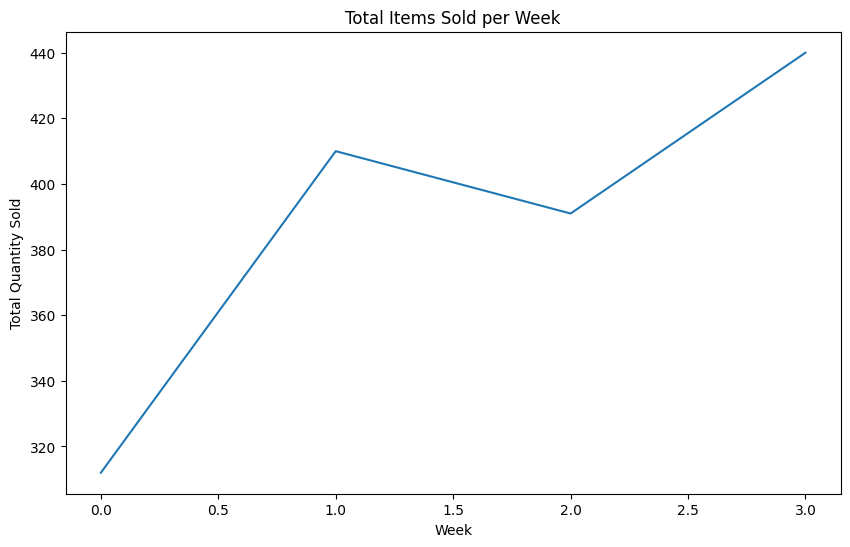

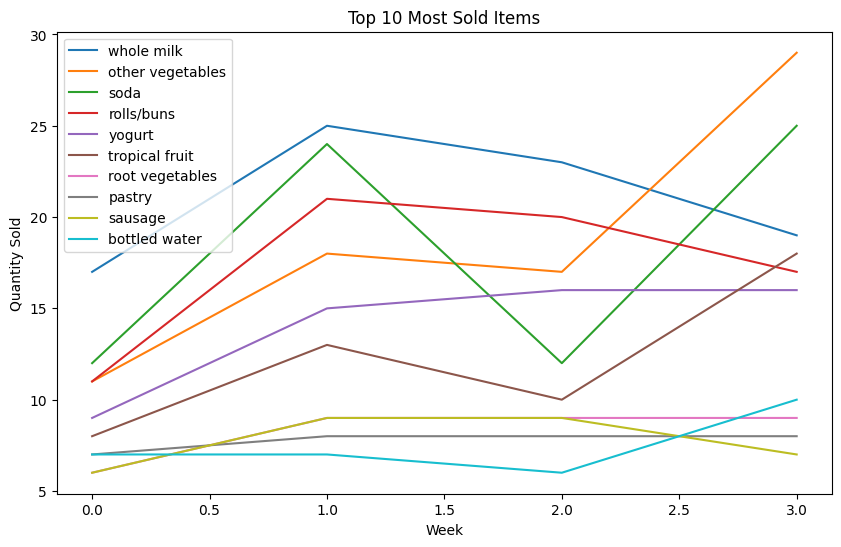

In [48]:
# 3. Plot all the items sold over the weeks
total_sales_per_week = reshaped_combined_sales.sum(axis=(0, 2))

plt.figure(figsize=(10, 6))
plt.plot(total_sales_per_week)
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.title('Total Items Sold per Week')
plt.show()

# 1. Pick the ten most sold items and plot them over the weeks
total_sales = reshaped_combined_sales.sum(axis=(0, 1))
top_ten_items = total_sales.argsort()[-10:][::-1]
top_ten_sales = reshaped_combined_sales[:, :, top_ten_items].sum(axis=0)

plt.figure(figsize=(10, 6))
for i, item_id in enumerate(top_ten_items):
    item_name = products_df.loc[products_df['product_id'] == item_id + 1, 'product_name'].values[0]
    plt.plot(top_ten_sales[:, i], label=item_name)
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.title('Top 10 Most Sold Items')
plt.legend()
plt.show()

We see that the predictions accurately capture seasonality and virality.